### First attempt at VMC
Using Variational Monte Carlo to find the ground state of a particle with potential $V(x) =\frac{1}{2} m\omega^2x^2 + \lambda x^4$.

We want to minimize the expected ground state energy:
$$\varepsilon = \frac{\int dX \, \psi^\dagger(X)\hat{H}\psi(X)}{\int dX\, \psi^\dagger(X) \psi(X)} = \frac{\int dX \, \psi^2(X)\psi^{-1}(X)\hat{H}\psi(X)}{\int dX\, \psi^2(X)}$$


In [168]:
import numpy as np
from matplotlib import pyplot as plt
import random
from scipy import integrate, optimize

# constants for the potential
m = 1
omega = 1
lam = 0
hbar = 1
N = 10**4
# potential function
def V(x):
    return 1/2*m * omega**2 * x**2 + lam * x**4

def psi(x, a):
    return np.exp(-x**2 * a)
def ddpsi(x,a):
    return 2*a*np.exp(-a*x**2)*(2*a*x**2 - 1)
def Hpsi(x,a):
    return V(x) * psi(x,a)  -hbar**2 / (2*m) * ddpsi(x,a)
def dlog_psi(x,a):
    return -x**2

def P(x, a):
    return psi(x, a)**2/integrate.quad(psi, -np.inf, np.inf,args=(a,))[0]

# function that samples the probability distribution P, n times
# uses the metropolis algorithm
# for any more than n=1, returns an array
def sample(a, n = 1):
    outputs = []

    # pick the start point
    x_t = 0
    for t in range(n):
        x_prime = x_t + random.uniform(-1,1)
        
        if (random.uniform(0,1) < P(x_prime, a)/P(x_t, a)):
            x_t = x_prime
        outputs.append(x_t)
    if n == 1:
        return outputs[0]
    return outputs


# now we define the approximation of the average, which uses the metropolis sampling
def avg_energy(N, a):
    # get N sampled points
    samples = sample(a, N)
    # apply the function to every point
    applied = [(1/psi(x_a, a) * Hpsi(x_a,a)) for x_a in samples]
    return 1/N * sum(applied)

# just a wrapper function for the average energy function

def avg_wrapper(a):
    return avg_energy(N, a)

# define the average of the derivative with respect to the parameter
# of the log of psi
def avg_dlogpsi(N,a):
    samples = sample(a,N)
    applied = [dlog_psi(x_a, a) for x_a in samples]
    return 1/N * sum(applied)

def avg_both(N,a):
    samples = sample(a,N)
    applied = [(1/psi(x_a,a) * dlog_psi(x_a, a) * Hpsi(x_a,a)) for x_a in samples]
    return 1/N * sum(applied)

def gradient(N, a):
    return 2 * avg_both(N,a) - 2 * avg_dlogpsi(N, a) * avg_energy(N, a)

In [169]:
a_vals = np.linspace(.1, 2, 30)
energies = [avg_energy(N, a) for a in a_vals]
a_min = optimize.minimize_scalar(avg_wrapper).x

C:\Users\Hersh\AppData\Local\Temp/ipykernel_12916/4265077594.py:26: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return psi(x, a)**2/integrate.quad(psi, -np.inf, np.inf,args=(a,))[0]


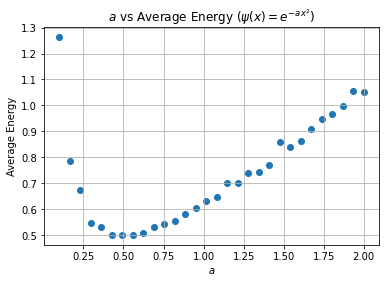

a value with minimum average energy: 0.46163157825596124
Minimum Energy: 0.5007753835688539
True Ground State Energy: 0.5


In [170]:
plt.scatter(a_vals, energies)
plt.title("$a$ vs Average Energy ($\psi(x) = e^{-ax^2}$)")
plt.xlabel("$a$")
plt.ylabel("Average Energy")
plt.grid()
plt.show()
print("a value with minimum average energy: "+ str(a_min))
print("Minimum Energy: " + str(avg_wrapper(a_min)))
print("True Ground State Energy: " + str(1/2 * hbar * omega))